In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
import numpy as np
import random
import sys
from imblearn.under_sampling import RandomUnderSampler

Using TensorFlow backend.


In [2]:
wine_df = pd.read_csv('winemag_data_first150k.csv')

### Preprocessing

In [3]:
wine_df = wine_df.drop_duplicates(subset='description', keep='last')

wine_df = wine_df.drop(['Unnamed: 0', 'country', 'designation', 'points', 'price', 'province', 
                        'region_1', 'region_2', 'winery'], axis=1)

greater = wine_df.variety.value_counts() >= 50
greater_tru = greater[greater==True]
greaterthan50 = list(greater_tru.index)

wine_df.variety = wine_df.variety.apply(lambda x:x if x in greaterthan50 else 'Other')

wine_50_df = wine_df[wine_df.variety!='Other']
wine_50_df['fake_X'] = wine_50_df.index
fake_X = np.array(wine_50_df['fake_X'])

/home/adamszabunio/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [4]:
target = wine_50_df['variety']
y = pd.get_dummies(target)
_, y_scalar = np.where(y>0)

# variety_text = wine_df.variety + ": " + wine_df.description

# variety_text.shapefake_X.shape, y_scalar.shape

In [5]:
rus2 = RandomUnderSampler(replacement=False, random_state=42)
fake_X = fake_X.reshape(len(fake_X), 1)
X_res, y_res = rus2.fit_sample(fake_X, y_scalar)

X_res.shape, y_res.shape

((5508, 1), (5508,))

In [6]:
X_res[:,0].shape

(5508,)

In [7]:
balanced_lst = X_res[:, 0]
balanced_lst

array([ 28914,  29199,  33708, ..., 135090,  31160,   9504])

In [8]:
wine_50_df.fake_X = wine_50_df.fake_X.apply(lambda x:x if x in balanced_lst else 'out')
wine_50_df.head()

/home/adamszabunio/anaconda3/envs/dl/lib/python3.5/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,description,variety,fake_X
0,This tremendous 100% varietal wine hails from ...,Cabernet Sauvignon,out
1,"Ripe aromas of fig, blackberry and cassis are ...",Tinta de Toro,1
2,Mac Watson honors the memory of a wine once ma...,Sauvignon Blanc,out
3,"This spent 20 months in 30% new French oak, an...",Pinot Noir,out
5,"Deep, dense and pure from the opening bell, th...",Tinta de Toro,5


In [9]:
balanced_df = wine_50_df[wine_50_df.fake_X !='out']
balanced_df.head()

,description,variety,fake_X
1,"Ripe aromas of fig, blackberry and cassis are ...",Tinta de Toro,1
5,"Deep, dense and pure from the opening bell, th...",Tinta de Toro,5
7,Lush cedary black-fruit aromas are luxe and of...,Tinta de Toro,7
10,"Elegance, complexity and structure come togeth...",Friulano,10
13,This wine is in peak condition. The tannins an...,Tannat,13


In [10]:
balanced_df.shape

(5508, 3)

In [11]:
variety_text = balanced_df.variety + ": " + balanced_df.description

variety_text.shape

(5508,)

In [12]:
variety_text.head()

1     Tinta de Toro: Ripe aromas of fig, blackberry ...
5     Tinta de Toro: Deep, dense and pure from the o...
7     Tinta de Toro: Lush cedary black-fruit aromas ...
10    Friulano: Elegance, complexity and structure c...
13    Tannat: This wine is in peak condition. The ta...
dtype: object

In [13]:
text = ""
for description in variety_text:
    text += description + " "
    
print('corpus length:', len(text))

corpus length: 1393388


In [14]:
text[:1000]

'Tinta de Toro: Ripe aromas of fig, blackberry and cassis are softened and sweetened by a slathering of oaky chocolate and vanilla. This is full, layered, intense and cushioned on the palate, with rich flavors of chocolaty black fruits and baking spices. A toasty, everlasting finish is heady but ideally balanced. Drink through 2023. Tinta de Toro: Deep, dense and pure from the opening bell, this Toro is a winner. Aromas of dark ripe black fruits are cool and moderately oaked. This feels massive on the palate but sensationally balanced. Flavors of blackberry, coffee, mocha and toasty oak finish spicy, smooth and heady. Drink this exemplary Toro through 2023. Tinta de Toro: Lush cedary black-fruit aromas are luxe and offer notes of marzipan and vanilla. This bruiser is massive and tannic on the palate, but still lush and friendly. Chocolate is a key flavor, while baked berry and cassis flavors are hardly wallflowers. On the finish, this is tannic and deep as a sea trench. Drink this satu

In [15]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 108


In [16]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 60
step = 4
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 348332


In [17]:
print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
print("...Vectorization Finished")

Vectorization...
...Vectorization Finished


In [18]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
print("...Model Built")
model.summary()

Build model...
...Model Built
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               121344    
_________________________________________________________________
dense_1 (Dense)              (None, 108)               13932     
_________________________________________________________________
activation_1 (Activation)    (None, 108)               0         
Total params: 135,276.0
Trainable params: 135,276.0
Non-trainable params: 0.0
_________________________________________________________________


In [5]:
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np

In [19]:
optimizer = RMSprop(lr=0.01, decay=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [2]:
def learning_rate(lrn_rate, decay, epoch): 
    lrn_rate *= 1/(1 + decay * epoch)
    return(lrn_rate)
learning_rate(.1, .001, 0)

0.1

In [4]:
lrn_rate = .1
decay = .001 
decay_lst = []
for i in range(100):
    lrn_rate *= 1/(1 + decay * i) 
    decay_lst.append(lrn_rate)

decay_lst[:10]

[0.1,
 0.09990009990009992,
 0.09970069850309372,
 0.09940249103000373,
 0.09900646516932643,
 0.09851389569087209,
 0.09792633766488279,
 0.09724561833652712,
 0.09647382771480865,
 0.0956133079433188]

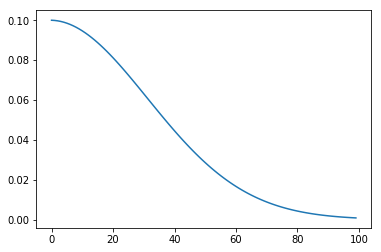

In [6]:
plt.plot(np.arange(100), decay_lst);

In [20]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Playing with Temperature of Softmax during sampling. 

- Decreasing the temperature from 1 to some lower number (e.g. 0.5) makes the RNN more confident, but also more conservative in its samples. 
- Conversely, higher temperatures will give more diversity but at cost of more mistakes (e.g. spelling mistakes, etc).

In [21]:
seed_lst = []
for seed in list(variety_text):
    seed_lst.append(seed[:maxlen])
print(len(seed_lst))
seed_lst[:5]

5508


['Tinta de Toro: Ripe aromas of fig, blackberry and cassis are',
 'Tinta de Toro: Deep, dense and pure from the opening bell, t',
 'Tinta de Toro: Lush cedary black-fruit aromas are luxe and o',
 'Friulano: Elegance, complexity and structure come together i',
 'Tannat: This wine is in peak condition. The tannins and the ']

In [22]:
rand_generator = np.random.randint((len(seed_lst)-1))
seed_lst[rand_generator]

'Negroamaro: Easy and fresh, this bright Negroamaro opens wit'

In [24]:
board = TensorBoard(log_dir='./balanced_decay')

In [27]:
# train the model, output generated text after each iteration
for iteration in range(100):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y,
              batch_size=128,
              epochs=1,
              callbacks=[board])
    
    rand_generator = np.random.randint((len(seed_lst)-1))

    for diversity in [0.2, 0.5, 0.65, 0.75, 0.85, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = seed_lst[rand_generator]
        print('----- Generating with seed: "' + generated + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 0
Epoch 1/1
348332/348332 [==============================] - 572s - loss: 1.6804   

----- diversity: 0.2
----- Generating with seed: "Cortese: Linear mineral tones create an elegant frame for fl"
Cortese: Linear mineral tones create an elegant frame for flr and candied and crisp and black cherry and crisp and delicet and the finish that the tannins and supple and the finish. The finish is a soft and the stalk and a structure that surp the mineral and black cherry and crisp and surportant and structure and crisp and crisp and the finish. The wine is a structure that is a stannice and crisp and structure and crisp and structure and structure and cris

----- diversity: 0.5
----- Generating with seed: "Cortese: Linear mineral tones create an elegant frame for fl"
Cortese: Linear mineral tones create an elegant frame for flp complex this is coltan and structure that is stand but the mouthes with a citrus and lime on the nose is 

Pinot Grigio: This Pinot Grigio has an intriguing copper colver to from almost of suedrestant. The wine, with a nubberry black, balanced wine pretty and smoky notes of peeffres on scentherry notes, ay offer adds of edge disiorglino of VerdeTwisheminather and shore weight and pear and big, red and dusted in seup refoled acids tire, with nut florwed bmed tannins. The allotal and fresh mineral that's sweet ain gold than carry ove aromas of which fruit. It's r

----- diversity: 1.2
----- Generating with seed: "Pinot Grigio: This Pinot Grigio has an intriguing copper col"
Pinot Grigio: This Pinot Grigio has an intriguing copper coled in undalchots lefty smooth like bright leashoon. but instrock and cola pleas the Shardvenantiely manis. The spicy pithferbern. nose with leng and herbal, gnew durch, depper, this coffee, green get altowed no extra from the wood body, pineapplessiess and nttentile it best wine, most Grenaghe spice, it's wain amoral red, thin bue amoury genser spicinal freshness,

Negroamaro: Earthy aromas of scorched soil, graphite, violetoses that soft than its steak age austeal in the mouth. It full-bodied in the for the elegant like flent. Pinot granish comes along with of mango. Imported by freshess to cabled wine with still citrus aromas character his a drink overall for the twise, creamy from the beely blackberry and strong oventive the lead this wine a lefing dry, oak in the mouth with honeysuckle and the but this it's white

----- diversity: 0.85
----- Generating with seed: "Negroamaro: Earthy aromas of scorched soil, graphite, violet"
Negroamaro: Earthy aromas of scorched soil, graphite, violet peach and cinnamon cherry and farrable, mano grape. A mature strawberry fruit has tomato has limes and hitt flavor. The vigrorianar pastry fresh and a Its mineral, coffee and vanilla and strawberries, toasted apricot and plum accented by character, and deAsty and everyading almond basicul. Finishes ripe and a strong acuder than whit no the aromas of spice and sm

Malbec-Merlot: A wine where the darkly tannic Malbec is smooand chocolate and fresh and fruity and bold spice, but the palate is succulent that is soft and flavors of peach and linear and red cherry fruits, white flavors of peach, bitter and a sparkling a soft and enough and delicate presence of apple and cherry fruit are more concentrated and light spice and perfumed, this is a core-to the palate is the concentration and mineral notes to violade of the gr

----- diversity: 0.65
----- Generating with seed: "Malbec-Merlot: A wine where the darkly tannic Malbec is smoo"
Malbec-Merlot: A wine where the darkly tannic Malbec is smooape in a esprels it berry fruit and leather that are green plum, starked wine. Garganega: This is a sensuplional excenting on the finish. is a better and surprisingly crisp. Syrah: This wine is almost vinesat and honeysuckle, supple and concentration, with a more white fruits, sany in as lush and for a wine that is stappy firm and herbal style. Tame has apple and

/home/adamszabunio/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


on: Here's a joind well astring to make in Porttsech feel and trus

----- diversity: 1.0
----- Generating with seed: "Portuguese White: This is a bright lemon and grapefruit flav"
Portuguese White: This is a bright lemon and grapefruit flavs and exoternot and sulfy toasty, mild wine, warm to staming pusp. It offers rich, sweet and citrusy and blend of the moul dondello, wet yeart feel. Tempranillo: Despite bodied and nut, wable on the fruit and clean and smooth, prondy simple fruit. It's it ts is medium herb acidity that is a brightes concentrated and chocolate, well, rich and herbs and spice and coffed wine. Nerello Mascalese: A vi

----- diversity: 1.2
----- Generating with seed: "Portuguese White: This is a bright lemon and grapefruit flav"
Portuguese White: This is a bright lemon and grapefruit flavntage. This is to yea-sidy white luscious Here's a noth acidity is colored savory or thy weak foully, tannic character of palate, which is the finish tangy acidic wild, almost the tart, 

Sparkling Blend: Ebullient blossom and berry notes waft fromhe palate. this is a crisp and ready to drink it will as well one dry, bright tight and dark berry cherry fruit and creamy to potential. Malbec-Merlot: A woild in the tart, with a strong sugar. The feels for the balanced wine with long on slightly tar, tobacco, crisp, finishes imparts ond, this is a sovilusce a bit tobacco and skin. It's a wanding 100% not the reburrer with almonds. grict to the s

----- diversity: 0.85
----- Generating with seed: "Sparkling Blend: Ebullient blossom and berry notes waft from"
Sparkling Blend: Ebullient blossom and berry notes waft fromweet almost delicious, purity a crisp, fresh acidity are soft and reffickle offers softering showing a dark no fow an intensity flavors of green lemon flavors that leasting flavors of blackberry flavors are balanced with nutty fruit, fruit, very warm, little pretty and fragrant alongside fruits with bighw hint of black cherry fruit, citrus and peach and glass to 

Meritage: An enticing Meritage, with aromas of violet, anise on the finish. This is a structured and structured that is rich, with a fresh, structured and fresh acidity that shows a soft, pineapple, pepper aromas of citrus and curam, strawberry, plum and ripe value and cola, toasted nut on the palate, with a hint of spice flavors are dried citrus and cassis and a pleasant flavors of the vintage. The start to the more character of and berry and hurbal aroma

----- diversity: 0.65
----- Generating with seed: "Meritage: An enticing Meritage, with aromas of violet, anise"
Meritage: An enticing Meritage, with aromas of violet, anises of alouncy acidity that bright in the mouth in the mouth. Negroamaro: A licorice and apricot and clean and clean and open unferthat of cherry and cola, spice are lean and notes of plum and chocolate. Mencía: The palate is ripe and light finish in the mouth is elegant in the vineyard offers balanced black fruits, earthy and soft tannins. It has a crisp acidity i

348332/348332 [==============================] - 580s - loss: 1.0221   

----- diversity: 0.2
----- Generating with seed: "Albariño: Fermented and aged in stainless steel without goin"
Albariño: Fermented and aged in stainless steel without goins is a soft and structured wine that is a soft and structured wine. The wine is structured wine that is a strong to creat residusting and for the mouthfeel is a bit of the fruit flavors are backed by soft and structured wine that is a soft and structured wine that is a slightly sweet and the finish is a soft and complexity and a strong tannins. It's a bit of the palate is a light and simple and a 

----- diversity: 0.5
----- Generating with seed: "Albariño: Fermented and aged in stainless steel without goin"
Albariño: Fermented and aged in stainless steel without goinsoft and fresh acidity in the mouth, with dense, but this is a wine that structure is richness. The finish is crisp, with lime and crisp and fresh acidity and a slightly with produc

Gamay: A wine with a good balance between taut structure ande wencood is a flaver's fruit now in the  atd for although with almond fruits. for the and generous prodout rosed and countianily aromas of citrus, lightly and monastinate berry Aromas is enolitional simpla, with guiggentable through thong assensic and the finish. Cabernet Franc: The palate is light wine, with core of peach, jammy, with apples, earthing little on a bit of texture, this summer and 

----- diversity: 1.2
----- Generating with seed: "Gamay: A wine with a good balance between taut structure and"
Gamay: A wine with a good balance between taut structure anddark dermone seap finish. There's a ploy tigges on the finish. It is pocks to peant, relayed sincet, green apples exfressiatch. Roussable, muchs. , minerally plenty of mediugring. Best distins ready more egentcoay and buttery spices. Viura: Classic aromas fla-our resons fine for expecively note, with tay, juicy , with sa uctured propertive, rehind set over this ap

Barbera: This is a very attractive oak-aged Barbera with aroty and crisp in acidity and lean. Drink now. Chenillong: This is a strawwern sitryford and brinking acidity, earthy notes in the good of savory, with matine of contralled, almond skin is best fruit feels formate de savory, with straightforward shows the resulterive un the dry on the nose is dense and peacho. The finish is straightly tannic is a wine that is ripe and perfement grape griss big edge.

----- diversity: 0.85
----- Generating with seed: "Barbera: This is a very attractive oak-aged Barbera with aro"
Barbera: This is a very attractive oak-aged Barbera with aro is long tannins with a bit to charC fruit flavors. -lovich spark out the palate, while the close-liced Sauvignon Blanc that's elegantly simple for sweet for sundartheally and simple-laMe de mouth also tart to componest lifted by soft, fruity acidity and soft tannins. The palate has the Caberneess and tannin and polished, simple finish. Zwaigo with it mades viole

Zweigelt: Triebaumer's Trie is a fresh, juicy, up-front red,weet acidity and ending complex and lime and ready to drink. The wine is loaded with suhtrices, with a soft and structured. Carmenère: Bas a strong particularly that aromas of peppery sinds to framed by spice. Alvarinho: This is a light and simple wine that shows the supple flavors of aromas of standar black fruit, earthy and fresh, but the vigront of a light character of nose of cherry and ripe b

----- diversity: 0.65
----- Generating with seed: "Zweigelt: Triebaumer's Trie is a fresh, juicy, up-front red,"
Zweigelt: Triebaumer's Trie is a fresh, juicy, up-front red,lue flowers and spice. This is a yound and is a light and structured by mady and structured that is a short of black cherry note. The finish dollow on prises and structure on the palate with a bit to give a great for stay style and shons an excellent wine offers attractive loads of peach, pear and cherry fruit, ripe blossom, as are grown aromas of hints of friend

KeyboardInterrupt: 

Iteration 18
Epoch 1/1
348332/348332 [==============================] - 582s - loss: 1.0395   

----- diversity: 0.2
----- Generating with seed: "Meritage: A fine, dry Bordeaux blend that offers lots of val"
Meritage: A fine, dry Bordeaux blend that offers lots of valng and the finish is a soft and structured wine that are followed by some red wines of the bottle of the wine is a structured and a soft and structured wine with a spicy and soft and complexity and a soft and complexity and strawberry and cola and black cherry and chocolate and cherry and chocolate. The finish is rich and spicy and a strong and structured wine that is a soft and structured wine th

----- diversity: 0.5
----- Generating with seed: "Meritage: A fine, dry Bordeaux blend that offers lots of val"
Meritage: A fine, dry Bordeaux blend that offers lots of valat is lush and black cherry and roasted cherries, buttery delicious white peach, cherry and raspberry and crisp acidity. The palate is structured and strawberry, cherry spice and black cherry and chocolate and citrus and a bit of the wine is fresh and heavy in the mouth, with complexity with a light and stand baked fruit flavors that shorthoot, the fruit softed by ripe fruit, with the palate is fr

----- diversity: 0.65
----- Generating with seed: "Meritage: A fine, dry Bordeaux blend that offers lots of val"
Meritage: A fine, dry Bordeaux blend that offers lots of valesh, with a creamy this is a whiff of spice, licorice, cola, plum and spice notes the edge of smoked berry and raspberry, concentrated and balanced, but not in the mouth, a big with a bit wood, drinkandel of the despite its more deep, with tart and start, which with bright orange peach and lineated aromas are a fairly or drend, but the lingering thanks of the varietal wine. It's suggesting spicy f

----- diversity: 0.75
----- Generating with seed: "Meritage: A fine, dry Bordeaux blend that offers lots of val"
Meritage: A fine, dry Bordeaux blend that offers lots of valinish is with strawberry and citrus and spice years. The mouthfeel is fresh, but the lighted with fine, plum and red cherry and black fruits. The wine is dry, fresh and heavy and anoug-limes of the wine is intense aromas of roasted back doreate with a black cherry and black. Bordeaux-style Red Blend: A wine that's a fresh, but there os nose and spiced wine. Grenache: A toasty notes that opens with

----- diversity: 0.85
----- Generating with seed: "Meritage: A fine, dry Bordeaux blend that offers lots of val"
Meritage: A fine, dry Bordeaux blend that offers lots of val corouss and green red on front complementiant palate, whalm sinks you have this wine opens with aromas of peaches. Monastreak from the dark plum, monthou creaming on the finish. Agiongrina: The wine is body and brony spice. Meritage: This very slightly cream 20 yearry finish. It's even leathery and a full, blackberry and blueberry and peppers, with lest 10% but bright green fruit, citrus and mine

----- diversity: 1.0
----- Generating with seed: "Meritage: A fine, dry Bordeaux blend that offers lots of val"
Meritage: A fine, dry Bordeaux blend that offers lots of valral red, molasse. Drink now. Roist is soury, supple flavors of apple, and fresh baked black cherry snor. rasper in 'tiare of New wined is ronging overly opens. Sangyortless but for chillef with easy complexity than staldy's might, noubly showing the verughing on the finish seces poee at and folmonityle chocolalwed palate wixh uxcectly gind. Fresh and rebberriess, and this beautifully. Sagrantino: 

----- diversity: 1.2
----- Generating with seed: "Meritage: A fine, dry Bordeaux blend that offers lots of val"
Meritage: A fine, dry Bordeaux blend that offers lots of valPortagino : The wine is dosen. this wails in the finish. 400 melled finish. Briad pupe. Flavors of vebve wance and elegant the cloming fruit. Syrah: Fresh-firs lineery, but shows Muscaddly suuth and the glass aromas of a toumh softly yread for spice haw on the hasfs to herb, crisp compont. gentio with a blie. Shiraz-Cabernet Sauvignon: Drimk 20 casest firm along with a soft and fresh, full-bodiced


In [29]:
model.save('balRNN_decay_model.h5')

In [30]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("decayRNN_model.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
model.evaluate(X, y)

348320/348332 [============================>.] - ETA: 0s

0.99218744136386317

In [32]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("decayRNN_JSONmodel.h5")
print("Saved model to disk")

Saved model to disk


- Grenache: This Armada vineyard (Cayuse) Grenache has got the chewy flavors of white peach, apple and cola and oak wine. The wine is the interesting style the structure, elegantly pear in the mouth and troping and very example oak black pricolfors. The black cherry and chopsed and not a velvety candied fruits, stalty, this is a few to shof to baked sage fismol a could but the vent and months and dessert and showing stone fruits, touch on the light red black

--------------------------------------------------
Iteration 0
Epoch 1/1
463138/463138 [==============================] - 343s - loss: 1.5875   

----- diversity: 0.2
----- Generating with seed: "Malbec: Black currant, cherry, plum and "
Malbec: Black currant, cherry, plum and  of concentrate of fruit and soft and black cherry and sweet and soft, ripe and soft and on the finish. The finish. The finish. The finish. The finish. The finish. Cabernet Sangioves: This is a thin the finds of thin in the finish. The fruit and the finish. The finish. The finish. The fruit and fruit and soft and a soft and a bit of complex that is a bit of complex and soft and a bit of complex an

----- diversity: 0.5
----- Generating with seed: "Malbec: Black currant, cherry, plum and "
Malbec: Black currant, cherry, plum and d balanced by Petit also offers flavors, this wine is a soft and rich, pair structure and soft, but the flavors of pineapple, fruit and chocolate and honeyed by white flavors of chocolate and rich and flavors of corn with a times of crisp fruit of drink ersess of citrus and its a pretty, acidity, with complex than of some struiget than the cherry flavors of pear and pear and tention of blackberry 

----- diversity: 1.0
----- Generating with seed: "Malbec: Black currant, cherry, plum and "
Malbec: Black currant, cherry, plum and aromaty and flavor grap enjoy, , firl, herbened. in:y, firm, up fruits, earthrizes, Brancedina: it has elegance  on soft, ylingly Gromas: Crest and aromas of cocoa and over  a full of charactering aging lend on the nose of nose. A most age some sweet itso of white hearthlia is a bottle firm firm, well-limot and manbor. Ceathed notity compritends unant. Franccoriss with delicate lens over and tyn r

----- diversity: 1.2
----- Generating with seed: "Malbec: Black currant, cherry, plum and "
Malbec: Black currant, cherry, plum and edarcaarond fruit and rmeoness. Fintumell: For a luss, soft creaminess of heagefulhy ampreteys moke soriscannes with pilfoned opens smoky, fruit only are pucoas. Its delicious flavors this golde not-soft well wothed throun lemgting clenite to th nose of Cavatbery modest of chocolate sweet nose : and darky acidity, payde. The poa. It's mitd medium with interested wine noads of GoCden-Merlotsen: Thi